In [1]:
# Utiliser le drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd

# Lire le fichier csv fusionné (indices acoustiques et habitat composition)
df_sorties = pd.read_csv('/content/gdrive/MyDrive/ListenToTheWild/habitat&acousticIndicesFinal.csv')
liste_colonne = df_sorties.columns.tolist()
print(liste_colonne)

['Unnamed: 0', 'file_name', 'station_name', 'ZCR', 'MEANt', 'VARt', 'SKEWt', 'KURTt', 'LEQt', 'BGNt', 'SNRt', 'MED', 'Ht', 'ACTtFraction', 'ACTtCount', 'ACTtMean', 'EVNtFraction', 'EVNtMean', 'EVNtCount', 'MEANf', 'VARf', 'SKEWf', 'KURTf', 'NBPEAKS', 'LEQf', 'ENRf', 'BGNf', 'SNRf', 'Hf', 'EAS', 'ECU', 'ECV', 'EPS', 'EPS_KURT', 'EPS_SKEW', 'ACI', 'NDSI', 'rBA', 'AnthroEnergy', 'BioEnergy', 'BI', 'ROU', 'ADI', 'AEI', 'LFC', 'MFC', 'HFC', 'ACTspFract', 'ACTspCount', 'ACTspMean', 'EVNspFract', 'EVNspMean', 'EVNspCount', 'TFSD', 'H_Havrda', 'H_Renyi', 'H_pairedShannon', 'H_gamma', 'H_GiniSimpson', 'RAOQ', 'AGI', 'ROItotal', 'ROIcover', 'Annee', 'Site_x', 'Position', 'Dynamique', 'Commune', 'LD', 'LID', 'Site_y', 'Code', 'Commune_y', 'Transect', 'SMMini', 'LAT', 'LON', 'total_edge_length_100', 'edge_density_100', 'Shannon_landscape_diversity_100', 'grass_and_shub_cover_100', 'deciduous_forest_cover_100', 'coniferous_forest_cover_100', 'mineral_cover_100', 'ice_and_snow_cover_100', 'water_cov

Prédiction globale sur quelques paramètres

In [ ]:
# On ne garde que les colonnnes qui nous intéressent
df = df_sorties[[ 'file_name', 'ZCR', 'MEANt', 'VARt', 'SKEWt', 'KURTt', 'LEQt', 'BGNt', 'SNRt', 'MED', 'Ht', 'ACTtFraction', 'ACTtCount',
                  'ACTtMean', 'EVNtFraction', 'EVNtMean', 'EVNtCount', 'MEANf', 'VARf', 'SKEWf', 'KURTf', 'NBPEAKS', 'LEQf',
                  'ENRf', 'BGNf', 'SNRf', 'Hf', 'EAS', 'ECU', 'ECV', 'EPS', 'EPS_KURT', 'EPS_SKEW', 'ACI', 'NDSI', 'rBA',
                  'AnthroEnergy', 'BioEnergy', 'BI', 'ROU', 'ADI', 'AEI', 'LFC', 'MFC', 'HFC', 'ACTspFract', 'ACTspCount',
                  'ACTspMean', 'EVNspFract', 'EVNspMean', 'EVNspCount', 'TFSD', 'H_Havrda', 'H_Renyi', 'H_pairedShannon',
                  'H_gamma', 'H_GiniSimpson', 'RAOQ', 'AGI', 'ROItotal', 'ROIcover',
                  'total_edge_length_100', 'edge_density_100', 'Shannon_landscape_diversity_100',
                  'total_edge_length_250', 'edge_density_250', 'Shannon_landscape_diversity_250',
                  'total_edge_length_500', 'edge_density_500', 'Shannon_landscape_diversity_500']].copy()

# regrouper les données suivant les plages horaires (4 plages pour l'instant)

# Créer l'ensemble des plages horaires
list_aux = list(range(24))
# Regrouper les éléments par 6
list_plages_horaires = [list_aux[i:i+6] for i in range(0, len(list_aux), 6)]

# Les dataframe de chaque plage horaire
df_aube = pd.DataFrame(columns=['file_name', 'ZCR', 'MEANt', 'VARt', 'SKEWt', 'KURTt', 'LEQt', 'BGNt', 'SNRt', 'MED', 'Ht',
                                'ACTtFraction', 'ACTtCount','ACTtMean', 'EVNtFraction', 'EVNtMean', 'EVNtCount', 'MEANf', 'VARf', 'SKEWf', 'KURTf', 'NBPEAKS', 'LEQf',
                                'ENRf', 'BGNf', 'SNRf', 'Hf', 'EAS', 'ECU', 'ECV', 'EPS', 'EPS_KURT', 'EPS_SKEW', 'ACI', 'NDSI', 'rBA',
                                'AnthroEnergy', 'BioEnergy', 'BI', 'ROU', 'ADI', 'AEI', 'LFC', 'MFC', 'HFC', 'ACTspFract', 'ACTspCount',
                                'ACTspMean', 'EVNspFract', 'EVNspMean', 'EVNspCount', 'TFSD', 'H_Havrda', 'H_Renyi', 'H_pairedShannon',
                                'H_gamma', 'H_GiniSimpson', 'RAOQ', 'AGI', 'ROItotal', 'ROIcover','total_edge_length_100',
                                'edge_density_100', 'Shannon_landscape_diversity_100','total_edge_length_250', 'edge_density_250',
                                'Shannon_landscape_diversity_250','total_edge_length_500', 'edge_density_500',
                                'Shannon_landscape_diversity_500'])

df_matin = df_aube.copy()

df_aprem = df_aube.copy()

df_soir = df_aube.copy()

# Entamer le processus d'assignation à la bonne classe

for index, row in df.iterrows():
        file_name_parts = row['file_name'].split('_')
        horaire = file_name_parts[2]
        heure = horaire[:2]

        if int(heure) in list_plages_horaires[0]:
          df_aube = df_aube.append(row, ignore_index=True)
        elif int(heure) in list_plages_horaires[1]:
          df_matin = df_matin.append(row, ignore_index=True)
        elif int(heure) in list_plages_horaires[2]:
          df_aprem = df_aprem.append(row, ignore_index=True)
        else:
          df_soir = df_soir.append(row, ignore_index=True)

<ipython-input-6-0495502b3621>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aprem = df_aprem.append(row, ignore_index=True)
<ipython-input-6-0495502b3621>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_soir = df_soir.append(row, ignore_index=True)
<ipython-input-6-0495502b3621>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aube = df_aube.append(row, ignore_index=True)
<ipython-input-6-0495502b3621>:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_matin = df_matin.append(row, ignore_index=True)


KeyboardInterrupt: 

# Aube

In [3]:
# Ne garder que les colonnes qui nous intéressent
df_aube.drop(columns=['file_name'], inplace = True)

# centrer et réduire
df_aube = (df_aube - df_aube.mean()) / df_aube.std()

# Les variables à prédire
Y = df_aube[['total_edge_length_100', 'edge_density_100', 'Shannon_landscape_diversity_100',
        'total_edge_length_250', 'edge_density_250', 'Shannon_landscape_diversity_250',
        'total_edge_length_500', 'edge_density_500', 'Shannon_landscape_diversity_500']]

# Ne garder que les prédicteurs
df_aube.drop(columns=[ 'total_edge_length_100', 'edge_density_100', 'Shannon_landscape_diversity_100',
                  'total_edge_length_250', 'edge_density_250', 'Shannon_landscape_diversity_250',
                  'total_edge_length_500', 'edge_density_500', 'Shannon_landscape_diversity_500'], inplace=True)

NameError: name 'df_aube' is not defined

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Ensembles de train et de test
X_train, X_test, y_train, y_test = train_test_split(df_aube, Y, test_size=0.2, random_state=42)

# Entraîner le modèle
rf_model.fit(X_train, y_train)

# Prédire à partir du modèle
y_pred = rf_model.predict(X_test)

In [ ]:
# Calcul de l'erreur relative
erreur_relative = np.abs((y_pred- y_test) / y_test) * 100
moyenne_relative = np.mean(erreur_relative, axis= 0)
mediane_relative = np.median(erreur_relative, axis = 0)
max_relatif = np.max(erreur_relative, axis = 0)
print('La moyenne erreur relative (Regression Forest) :\n', moyenne_relative)
print('---------------------------------------------------------------------------------------------------------------')
print('La médiane erreur relative (Regression Forest) :\n', mediane_relative)
print('---------------------------------------------------------------------------------------------------------------')
print('Le maximum erreur relative (Regression Forest) :\n', max_relatif)

La moyenne erreur relative (Regression Forest) :
 total_edge_length_100              104.293391
edge_density_100                   104.293486
Shannon_landscape_diversity_100     82.561636
total_edge_length_250              118.807092
edge_density_250                   118.807087
Shannon_landscape_diversity_250     72.456459
total_edge_length_500               85.607291
edge_density_500                    85.607084
Shannon_landscape_diversity_500    136.847065
dtype: float64
---------------------------------------------------------------------------------------------------------------
La médiane erreur relative (Regression Forest) :
 [60.35013834 60.35011914 54.03540399 66.11167692 66.11169639 54.93910489
 64.79464229 64.79454901 62.50197513]
---------------------------------------------------------------------------------------------------------------
Le maximum erreur relative (Regression Forest) :
 total_edge_length_100              2530.871354
edge_density_100                   2530

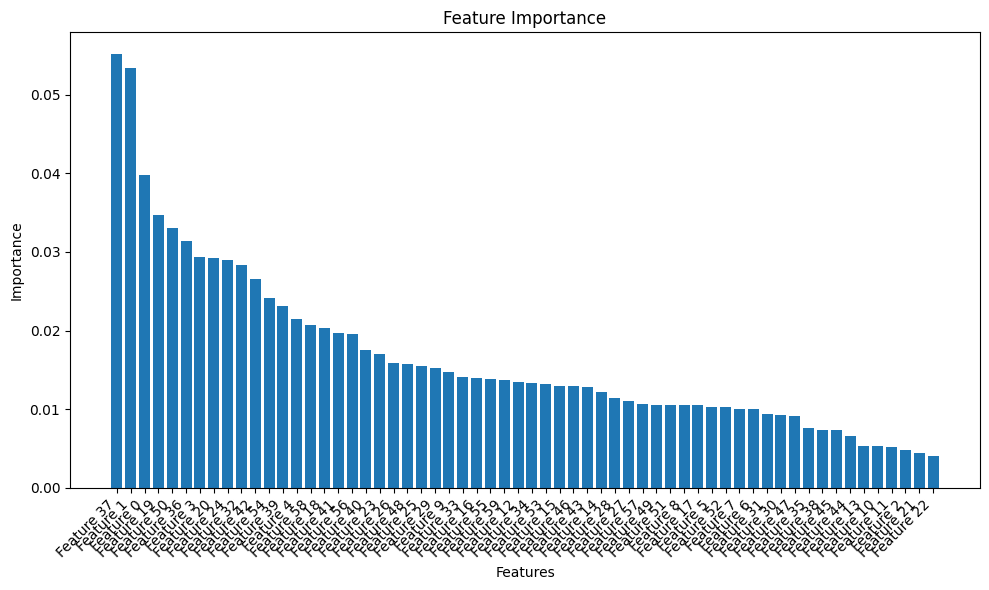

Index(['BioEnergy', 'ZCR', 'file_name', 'SKEWf', 'EVNspCount', 'AnthroEnergy',
       'VARt', 'KURTf', 'BGNf', 'EPS_SKEW'],
      dtype='object')


In [ ]:
import matplotlib.pyplot as plt

# sélectionner l'importance des features
feature_importances = rf_model.feature_importances_

# Trier l'importance des features par ordre décroissant
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = np.array([f"Feature {i}" for i in sorted_indices])

# Afficher l'importance des features
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), sorted_feature_importances, tick_label=sorted_feature_names)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Select the most important features (e.g., top 10)
top_features_indices = feature_importances.argsort()[-10:][::-1]  # Select top 10 features

# top 10 des indices acoustiques
liste_aube = df.columns[top_features_indices]

print(liste_aube)

# Matin

In [ ]:
# Ne garder que les colonnes qui nous intéressent
df_matin.drop(columns=['file_name'], inplace = True)

# centrer et réduire
df_matin = (df_matin - df_matin.mean()) / df_matin.std()

# Les variables à prédire
Y = df_matin[['total_edge_length_100', 'edge_density_100', 'Shannon_landscape_diversity_100',
        'total_edge_length_250', 'edge_density_250', 'Shannon_landscape_diversity_250',
        'total_edge_length_500', 'edge_density_500', 'Shannon_landscape_diversity_500']]

# Ne garder que les prédicteurs
df_matin.drop(columns=[ 'total_edge_length_100', 'edge_density_100', 'Shannon_landscape_diversity_100',
                  'total_edge_length_250', 'edge_density_250', 'Shannon_landscape_diversity_250',
                  'total_edge_length_500', 'edge_density_500', 'Shannon_landscape_diversity_500'], inplace=True)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np

rf_model1 = RandomForestRegressor(n_estimators=100, random_state=42)

# Ensembles de train et de test
X_train, X_test, y_train, y_test = train_test_split(df_matin, Y, test_size=0.2, random_state=42)

# Entraîner le modèle
rf_model1.fit(X_train, y_train)

# Prédire à partir du modèle
y_pred = rf_model1.predict(X_test)

In [ ]:
# Calcul de l'erreur relative
erreur_relative = np.abs((y_pred- y_test) / y_test) * 100
moyenne_relative = np.mean(erreur_relative, axis= 0)
mediane_relative = np.median(erreur_relative, axis = 0)
max_relatif = np.max(erreur_relative, axis = 0)
print('La moyenne erreur relative (Regression Forest) :\n', moyenne_relative)
print('---------------------------------------------------------------------------------------------------------------')
print('La médiane erreur relative (Regression Forest) :\n', mediane_relative)
print('---------------------------------------------------------------------------------------------------------------')
print('Le maximum erreur relative (Regression Forest) :\n', max_relatif)

La moyenne erreur relative (Regression Forest) :
 total_edge_length_100              130.600270
edge_density_100                   130.600673
Shannon_landscape_diversity_100    165.920065
total_edge_length_250              145.191930
edge_density_250                   145.191928
Shannon_landscape_diversity_250     90.169483
total_edge_length_500              105.978573
edge_density_500                   105.978849
Shannon_landscape_diversity_500    201.859331
dtype: float64
---------------------------------------------------------------------------------------------------------------
La médiane erreur relative (Regression Forest) :
 [74.00138564 74.00138314 62.55968775 78.80297075 78.80297372 67.79769822
 78.73875843 78.73877077 79.34536531]
---------------------------------------------------------------------------------------------------------------
Le maximum erreur relative (Regression Forest) :
 total_edge_length_100               2577.976050
edge_density_100                    25

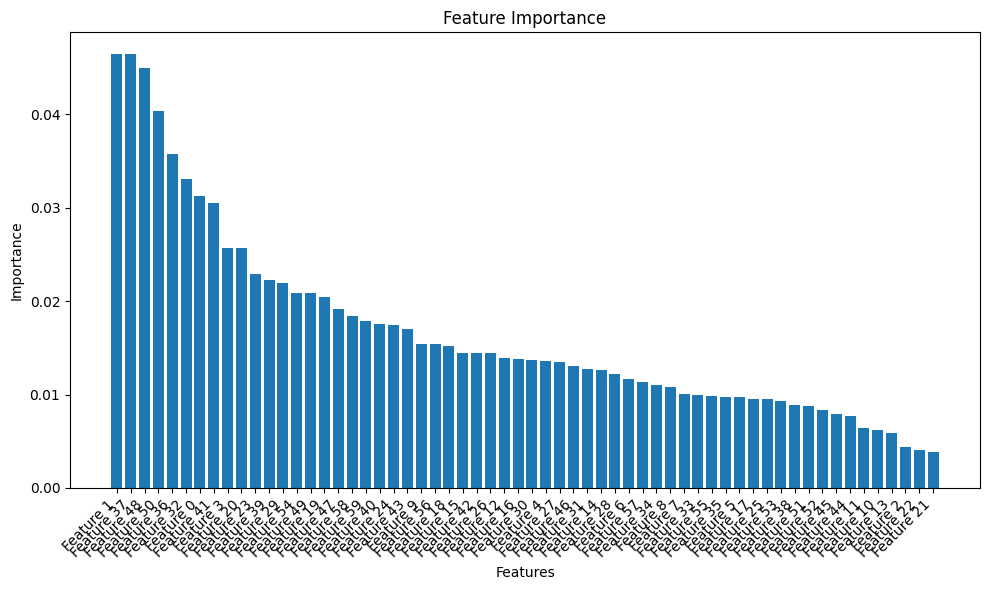

Index(['ZCR', 'BioEnergy', 'EVNspFract', 'EVNspCount', 'AnthroEnergy',
       'EPS_SKEW', 'file_name', 'AEI', 'VARt', 'KURTf'],
      dtype='object')


In [ ]:
import matplotlib.pyplot as plt

# sélectionner l'importance des features
feature_importances = rf_model1.feature_importances_

# Trier l'importance des features par ordre décroissant
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = np.array([f"Feature {i}" for i in sorted_indices])

# Afficher l'importance des features
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), sorted_feature_importances, tick_label=sorted_feature_names)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Select the most important features (e.g., top 10)
top_features_indices = feature_importances.argsort()[-10:][::-1]  # Select top 10 features

# top 10 des indices acoustiques
liste_matin = df.columns[top_features_indices]

print(liste_matin)

# Aprem

In [ ]:
# Ne garder que les colonnes qui nous intéressent
df_aprem.drop(columns=['file_name'], inplace = True)

# centrer et réduire
df_aprem = (df_aprem - df_aprem.mean()) / df_aprem.std()

# Les variables à prédire
Y = df_aprem[['total_edge_length_100', 'edge_density_100', 'Shannon_landscape_diversity_100',
        'total_edge_length_250', 'edge_density_250', 'Shannon_landscape_diversity_250',
        'total_edge_length_500', 'edge_density_500', 'Shannon_landscape_diversity_500']]

# Ne garder que les prédicteurs
df_aprem.drop(columns=[ 'total_edge_length_100', 'edge_density_100', 'Shannon_landscape_diversity_100',
                  'total_edge_length_250', 'edge_density_250', 'Shannon_landscape_diversity_250',
                  'total_edge_length_500', 'edge_density_500', 'Shannon_landscape_diversity_500'], inplace=True)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np

rf_model2 = RandomForestRegressor(n_estimators=100, random_state=42)

# Ensembles de train et de test
X_train, X_test, y_train, y_test = train_test_split(df_aprem, Y, test_size=0.2, random_state=42)

# Entraîner le modèle
rf_model2.fit(X_train, y_train)

# Prédire à partir du modèle
y_pred = rf_model2.predict(X_test)

In [ ]:
# Calcul de l'erreur relative
erreur_relative = np.abs((y_pred- y_test) / y_test) * 100
moyenne_relative = np.mean(erreur_relative, axis= 0)
mediane_relative = np.median(erreur_relative, axis = 0)
max_relatif = np.max(erreur_relative, axis = 0)
print('La moyenne erreur relative (Regression Forest) :\n', moyenne_relative)
print('---------------------------------------------------------------------------------------------------------------')
print('La médiane erreur relative (Regression Forest) :\n', mediane_relative)
print('---------------------------------------------------------------------------------------------------------------')
print('Le maximum erreur relative (Regression Forest) :\n', max_relatif)

La moyenne erreur relative (Regression Forest) :
 total_edge_length_100              118.885023
edge_density_100                   118.885438
Shannon_landscape_diversity_100    417.344735
total_edge_length_250              149.750952
edge_density_250                   149.750843
Shannon_landscape_diversity_250     94.829637
total_edge_length_500              105.373809
edge_density_500                   105.373901
Shannon_landscape_diversity_500    186.798356
dtype: float64
---------------------------------------------------------------------------------------------------------------
La médiane erreur relative (Regression Forest) :
 [73.02090332 73.02238253 64.85986086 82.2163776  82.21634866 68.84680138
 75.44289894 75.44291085 76.55621778]
---------------------------------------------------------------------------------------------------------------
Le maximum erreur relative (Regression Forest) :
 total_edge_length_100               5799.100791
edge_density_100                    57

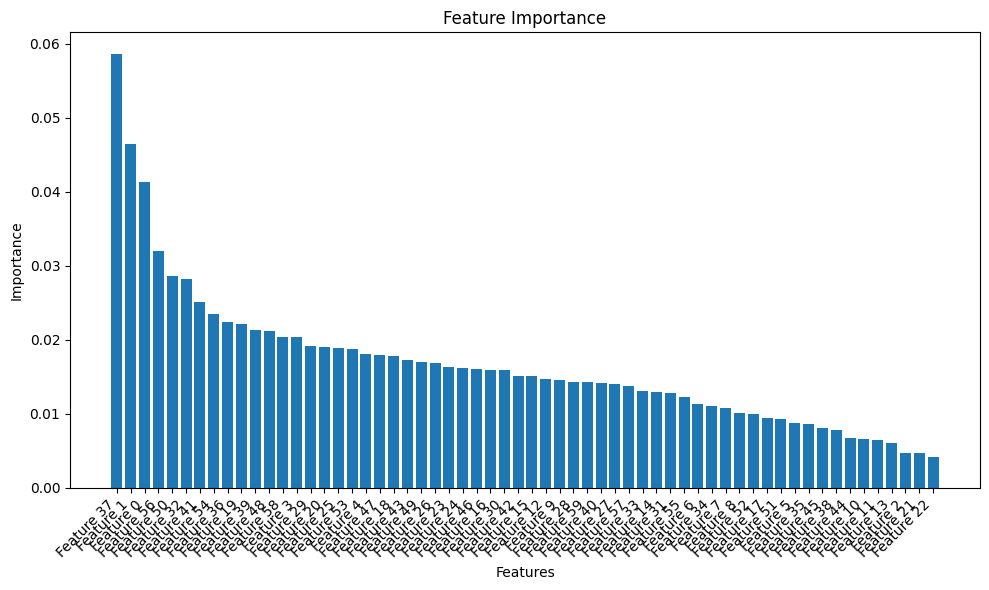

Index(['BioEnergy', 'ZCR', 'file_name', 'H_GiniSimpson', 'EVNspCount',
       'EPS_SKEW', 'AEI', 'H_pairedShannon', 'AnthroEnergy', 'SKEWf'],
      dtype='object')


In [ ]:
import matplotlib.pyplot as plt

# sélectionner l'importance des features
feature_importances = rf_model2.feature_importances_

# Trier l'importance des features par ordre décroissant
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = np.array([f"Feature {i}" for i in sorted_indices])

# Afficher l'importance des features
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), sorted_feature_importances, tick_label=sorted_feature_names)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Select the most important features (e.g., top 10)
top_features_indices = feature_importances.argsort()[-10:][::-1]  # Select top 10 features

# top 10 des indices acoustiques
liste_aprem = df.columns[top_features_indices]

print(liste_aprem)

# Soir

In [ ]:
# Ne garder que les colonnes qui nous intéressent
df_soir.drop(columns=['file_name'], inplace = True)

# centrer et réduire
df_soir = (df_soir - df_soir.mean()) / df_soir.std()

# Les variables à prédire
Y = df_soir[['total_edge_length_100', 'edge_density_100', 'Shannon_landscape_diversity_100',
        'total_edge_length_250', 'edge_density_250', 'Shannon_landscape_diversity_250',
        'total_edge_length_500', 'edge_density_500', 'Shannon_landscape_diversity_500']]

# Ne garder que les prédicteurs
df_soir.drop(columns=[ 'total_edge_length_100', 'edge_density_100', 'Shannon_landscape_diversity_100',
                  'total_edge_length_250', 'edge_density_250', 'Shannon_landscape_diversity_250',
                  'total_edge_length_500', 'edge_density_500', 'Shannon_landscape_diversity_500'], inplace=True)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np

rf_model3 = RandomForestRegressor(n_estimators=100, random_state=42)

# Ensembles de train et de test
X_train, X_test, y_train, y_test = train_test_split(df_soir, Y, test_size=0.2, random_state=42)

# Entraîner le modèle
rf_model3.fit(X_train, y_train)

# Prédire à partir du modèle
y_pred = rf_model3.predict(X_test)

In [ ]:
# Calcul de l'erreur relative
erreur_relative = np.abs((y_pred- y_test) / y_test) * 100
moyenne_relative = np.mean(erreur_relative, axis= 0)
mediane_relative = np.median(erreur_relative, axis = 0)
max_relatif = np.max(erreur_relative, axis = 0)
print('La moyenne erreur relative (Regression Forest) :\n', moyenne_relative)
print('---------------------------------------------------------------------------------------------------------------')
print('La médiane erreur relative (Regression Forest) :\n', mediane_relative)
print('---------------------------------------------------------------------------------------------------------------')
print('Le maximum erreur relative (Regression Forest) :\n', max_relatif)

La moyenne erreur relative (Regression Forest) :
 total_edge_length_100              125.903285
edge_density_100                   125.903984
Shannon_landscape_diversity_100    100.655335
total_edge_length_250              122.361991
edge_density_250                   122.361873
Shannon_landscape_diversity_250     85.763349
total_edge_length_500              196.444306
edge_density_500                   196.362771
Shannon_landscape_diversity_500    961.207138
dtype: float64
---------------------------------------------------------------------------------------------------------------
La médiane erreur relative (Regression Forest) :
 [75.6021919  75.60217753 67.51141626 80.25185667 80.25184845 70.10192393
 79.04667401 79.04665836 76.12337112]
---------------------------------------------------------------------------------------------------------------
Le maximum erreur relative (Regression Forest) :
 total_edge_length_100               12071.339190
edge_density_100                    1

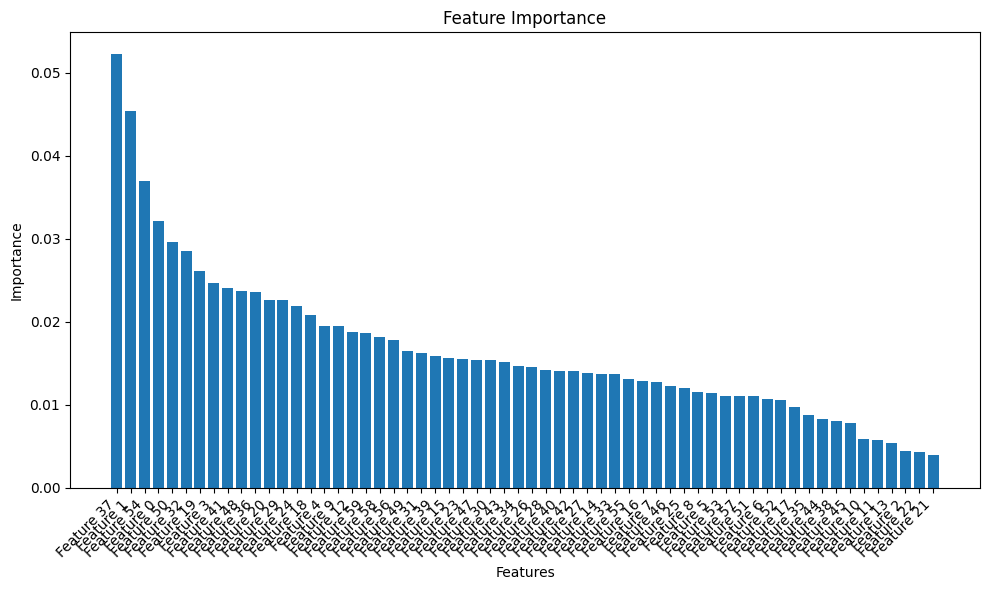

Index(['BioEnergy', 'ZCR', 'H_pairedShannon', 'file_name', 'EVNspCount',
       'EPS_SKEW', 'SKEWf', 'VARt', 'AEI', 'EVNspFract'],
      dtype='object')


In [ ]:
import matplotlib.pyplot as plt

# sélectionner l'importance des features
feature_importances = rf_model3.feature_importances_

# Trier l'importance des features par ordre décroissant
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = np.array([f"Feature {i}" for i in sorted_indices])

# Afficher l'importance des features
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), sorted_feature_importances, tick_label=sorted_feature_names)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Select the most important features (e.g., top 10)
top_features_indices = feature_importances.argsort()[-10:][::-1]  # Select top 10 features

# top 10 des indices acoustiques
liste_soir = df.columns[top_features_indices]

print(liste_soir)

In [ ]:
# Répérer les indices acoustiques qui reviennent le plus souvent
listes = []
listes.append(liste_aube.tolist())
listes.append(liste_matin.tolist())
listes.append(liste_aprem.tolist())
listes.append(liste_soir.tolist())

print(listes)

# Aplatir la liste
flattened_list = [item for sublist in listes for item in sublist]
print(flattened_list)
print(len(flattened_list))

ac = ['ZCR', 'MEANt', 'VARt', 'SKEWt', 'KURTt', 'LEQt', 'BGNt', 'SNRt', 'MED', 'Ht', 'ACTtFraction', 'ACTtCount',
      'ACTtMean', 'EVNtFraction', 'EVNtMean', 'EVNtCount', 'MEANf', 'VARf', 'SKEWf', 'KURTf', 'NBPEAKS', 'LEQf',
      'ENRf', 'BGNf', 'SNRf', 'Hf', 'EAS', 'ECU', 'ECV', 'EPS', 'EPS_KURT', 'EPS_SKEW', 'ACI', 'NDSI', 'rBA',
      'AnthroEnergy', 'BioEnergy', 'BI', 'ROU', 'ADI', 'AEI', 'LFC', 'MFC', 'HFC', 'ACTspFract', 'ACTspCount',
      'ACTspMean', 'EVNspFract', 'EVNspMean', 'EVNspCount', 'TFSD', 'H_Havrda', 'H_Renyi', 'H_pairedShannon',
      'H_gamma', 'H_GiniSimpson', 'RAOQ', 'AGI', 'ROItotal', 'ROIcover']

my_dict = {key: None for key in ac}

for elt in ac:
  count = flattened_list.count(elt)
  my_dict[elt] = count

sorted_dict = dict(sorted(my_dict.items(), key=lambda item: item[1], reverse=True))

print(sorted_dict)

[['BioEnergy', 'ZCR', 'file_name', 'SKEWf', 'EVNspCount', 'AnthroEnergy', 'VARt', 'KURTf', 'BGNf', 'EPS_SKEW'], ['ZCR', 'BioEnergy', 'EVNspFract', 'EVNspCount', 'AnthroEnergy', 'EPS_SKEW', 'file_name', 'AEI', 'VARt', 'KURTf'], ['BioEnergy', 'ZCR', 'file_name', 'H_GiniSimpson', 'EVNspCount', 'EPS_SKEW', 'AEI', 'H_pairedShannon', 'AnthroEnergy', 'SKEWf'], ['BioEnergy', 'ZCR', 'H_pairedShannon', 'file_name', 'EVNspCount', 'EPS_SKEW', 'SKEWf', 'VARt', 'AEI', 'EVNspFract']]
['BioEnergy', 'ZCR', 'file_name', 'SKEWf', 'EVNspCount', 'AnthroEnergy', 'VARt', 'KURTf', 'BGNf', 'EPS_SKEW', 'ZCR', 'BioEnergy', 'EVNspFract', 'EVNspCount', 'AnthroEnergy', 'EPS_SKEW', 'file_name', 'AEI', 'VARt', 'KURTf', 'BioEnergy', 'ZCR', 'file_name', 'H_GiniSimpson', 'EVNspCount', 'EPS_SKEW', 'AEI', 'H_pairedShannon', 'AnthroEnergy', 'SKEWf', 'BioEnergy', 'ZCR', 'H_pairedShannon', 'file_name', 'EVNspCount', 'EPS_SKEW', 'SKEWf', 'VARt', 'AEI', 'EVNspFract']
40
60
{'ZCR': 4, 'EPS_SKEW': 4, 'BioEnergy': 4, 'EVNspCount'

# Un modèle pour chaque paramètre


### Décomposer la banque générale en banque par plages horaires de six heures

In [ ]:
# On ne garde que les colonnnes qui nous intéressent
df = df_sorties[[ 'file_name', 'ZCR', 'MEANt', 'VARt', 'SKEWt', 'KURTt', 'LEQt', 'BGNt', 'SNRt', 'MED', 'Ht', 'ACTtFraction', 'ACTtCount',
                  'ACTtMean', 'EVNtFraction', 'EVNtMean', 'EVNtCount', 'MEANf', 'VARf', 'SKEWf', 'KURTf', 'NBPEAKS', 'LEQf',
                  'ENRf', 'BGNf', 'SNRf', 'Hf', 'EAS', 'ECU', 'ECV', 'EPS', 'EPS_KURT', 'EPS_SKEW', 'ACI', 'NDSI', 'rBA',
                  'AnthroEnergy', 'BioEnergy', 'BI', 'ROU', 'ADI', 'AEI', 'LFC', 'MFC', 'HFC', 'ACTspFract', 'ACTspCount',
                  'ACTspMean', 'EVNspFract', 'EVNspMean', 'EVNspCount', 'TFSD', 'H_Havrda', 'H_Renyi', 'H_pairedShannon',
                  'H_gamma', 'H_GiniSimpson', 'RAOQ', 'AGI', 'ROItotal', 'ROIcover',
                  'SMMini', 'LAT', 'LON', 'total_edge_length_100', 'edge_density_100', 'Shannon_landscape_diversity_100',
                  'grass_and_shub_cover_100', 'deciduous_forest_cover_100', 'coniferous_forest_cover_100', 'mineral_cover_100',
                  'ice_and_snow_cover_100', 'water_cover_100', 'total_edge_length_250', 'edge_density_250',
                  'Shannon_landscape_diversity_250', 'grass_and_shub_cover_250', 'deciduous_forest_cover_250',
                  'coniferous_forest_cover_250', 'mineral_cover_250', 'ice_and_snow_cover_250', 'water_cover_250',
                  'total_edge_length_500', 'edge_density_500', 'Shannon_landscape_diversity_500', 'grass_and_shub_cover_500',
                  'deciduous_forest_cover_500', 'coniferous_forest_cover_500', 'mineral_cover_500', 'ice_and_snow_cover_500',
                  'water_cover_500']].copy()

# regrouper les données suivant les plages horaires (4 plages pour l'instant)

# Créer l'ensemble des plages horaires
list_aux = list(range(24))
# Regrouper les éléments par 6
list_plages_horaires = [list_aux[i:i+6] for i in range(0, len(list_aux), 6)]

# Les dataframe de chaque plage horaire
df_aube = pd.DataFrame(columns=['file_name', 'ZCR', 'MEANt', 'VARt', 'SKEWt', 'KURTt', 'LEQt', 'BGNt', 'SNRt', 'MED', 'Ht', 'ACTtFraction', 'ACTtCount',
                                'ACTtMean', 'EVNtFraction', 'EVNtMean', 'EVNtCount', 'MEANf', 'VARf', 'SKEWf', 'KURTf', 'NBPEAKS', 'LEQf',
                                'ENRf', 'BGNf', 'SNRf', 'Hf', 'EAS', 'ECU', 'ECV', 'EPS', 'EPS_KURT', 'EPS_SKEW', 'ACI', 'NDSI', 'rBA',
                                'AnthroEnergy', 'BioEnergy', 'BI', 'ROU', 'ADI', 'AEI', 'LFC', 'MFC', 'HFC', 'ACTspFract', 'ACTspCount',
                                'ACTspMean', 'EVNspFract', 'EVNspMean', 'EVNspCount', 'TFSD', 'H_Havrda', 'H_Renyi', 'H_pairedShannon',
                                'H_gamma', 'H_GiniSimpson', 'RAOQ', 'AGI', 'ROItotal', 'ROIcover',
                                'SMMini', 'LAT', 'LON', 'total_edge_length_100', 'edge_density_100', 'Shannon_landscape_diversity_100',
                                'grass_and_shub_cover_100', 'deciduous_forest_cover_100', 'coniferous_forest_cover_100', 'mineral_cover_100',
                                'ice_and_snow_cover_100', 'water_cover_100', 'total_edge_length_250', 'edge_density_250',
                                'Shannon_landscape_diversity_250', 'grass_and_shub_cover_250', 'deciduous_forest_cover_250',
                                'coniferous_forest_cover_250', 'mineral_cover_250', 'ice_and_snow_cover_250', 'water_cover_250',
                                'total_edge_length_500', 'edge_density_500', 'Shannon_landscape_diversity_500', 'grass_and_shub_cover_500',
                                'deciduous_forest_cover_500', 'coniferous_forest_cover_500', 'mineral_cover_500', 'ice_and_snow_cover_500',
                                'water_cover_500'])

df_matin = df_aube.copy()

df_aprem = df_aube.copy()

df_soir = df_aube.copy()

# Entamer le processus d'assignation à la bonne classe

for index, row in df.iterrows():
        file_name_parts = row['file_name'].split('_')
        horaire = file_name_parts[2]
        heure = horaire[:2]

        if int(heure) in list_plages_horaires[0]:
          df_aube = df_aube.append(row, ignore_index=True)
        elif int(heure) in list_plages_horaires[1]:
          df_matin = df_matin.append(row, ignore_index=True)
        elif int(heure) in list_plages_horaires[2]:
          df_aprem = df_aprem.append(row, ignore_index=True)
        else:
          df_soir = df_soir.append(row, ignore_index=True)

df_aube.drop(columns = ['file_name'], inplace = True)
df_matin.drop(columns = ['file_name'], inplace = True)
df_aprem.drop(columns = ['file_name'], inplace = True)
df_soir.drop(columns = ['file_name'], inplace = True)

# centrer et reduire la donnée
df_aube = (df_aube - df_aube.mean()) / df_aube.std()
df_matin = (df_matin - df_matin.mean()) / df_matin.std()
df_aprem = (df_aprem - df_aprem.mean()) / df_aprem.std()
df_soir = (df_soir - df_soir.mean()) / df_soir.std()

<ipython-input-3-762109bbc699>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aprem = df_aprem.append(row, ignore_index=True)
<ipython-input-3-762109bbc699>:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_soir = df_soir.append(row, ignore_index=True)
<ipython-input-3-762109bbc699>:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aube = df_aube.append(row, ignore_index=True)
<ipython-input-3-762109bbc699>:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_matin = df_matin.append(row, ignore_index=True)


KeyboardInterrupt: 

In [4]:
df_original_aube = pd.read_csv('/content/gdrive/MyDrive/ListenToTheWild/regression/regression_creneaux/aube.csv')
df_original_matin = pd.read_csv('/content/gdrive/MyDrive/ListenToTheWild/regression/regression_creneaux/matin.csv')
df_original_aprem = pd.read_csv('/content/gdrive/MyDrive/ListenToTheWild/regression/regression_creneaux/aprem.csv')
df_original_soir = pd.read_csv('/content/gdrive/MyDrive/ListenToTheWild/regression/regression_creneaux/soir.csv')

df_aube = df_original_aube.drop(columns=['file_name'])
df_matin = df_original_matin.drop(columns=['file_name'])
df_aprem = df_original_aprem.drop(columns=['file_name'])
df_soir = df_original_soir.drop(columns=['file_name'])

# centrer et reduire la donnée
df_aube = (df_aube - df_aube.mean()) / df_aube.std()
df_matin = (df_matin - df_matin.mean()) / df_matin.std()
df_aprem = (df_aprem - df_aprem.mean()) / df_aprem.std()
df_soir = (df_soir - df_soir.mean()) / df_soir.std()


# detecteur les colonnes où il y des NaN

def detecteur_NaN(df):
  if df.isna().any().any():
    columns_with_nan = df.columns[df.isna().any()].tolist()
    print("Columns with NaN values:", columns_with_nan)

print("Aube")
detecteur_NaN(df_aube)
print()
print("Matin")
detecteur_NaN(df_matin)
print()
print("Aprem")
detecteur_NaN(df_aprem)
print()
print("Soir")
detecteur_NaN(df_soir)

Aube
Columns with NaN values: ['ice_and_snow_cover_100', 'ice_and_snow_cover_250']

Matin
Columns with NaN values: ['ice_and_snow_cover_100', 'ice_and_snow_cover_250']

Aprem
Columns with NaN values: ['ice_and_snow_cover_100', 'ice_and_snow_cover_250']

Soir
Columns with NaN values: ['ice_and_snow_cover_100', 'ice_and_snow_cover_250']


In [5]:
# Au vu des résultats, on abandonne les paramètres ice_and_snow_cover_100 et ice_and_snow_cover_250
df_aube.drop(columns=['ice_and_snow_cover_100', 'ice_and_snow_cover_250'], inplace = True)
df_matin.drop(columns=['ice_and_snow_cover_100', 'ice_and_snow_cover_250'], inplace = True)
df_aprem.drop(columns=['ice_and_snow_cover_100', 'ice_and_snow_cover_250'], inplace = True)
df_soir.drop(columns=['ice_and_snow_cover_100', 'ice_and_snow_cover_250'], inplace = True)

In [6]:
liste_a_predire = [ 'SMMini', 'LAT', 'LON', 'total_edge_length_100', 'edge_density_100', 'Shannon_landscape_diversity_100',
                    'grass_and_shub_cover_100', 'deciduous_forest_cover_100', 'coniferous_forest_cover_100', 'mineral_cover_100',
                    'water_cover_100', 'total_edge_length_250', 'edge_density_250','Shannon_landscape_diversity_250',
                    'grass_and_shub_cover_250', 'deciduous_forest_cover_250','coniferous_forest_cover_250', 'mineral_cover_250',
                    'water_cover_250','total_edge_length_500', 'edge_density_500', 'Shannon_landscape_diversity_500',
                    'grass_and_shub_cover_500','deciduous_forest_cover_500', 'coniferous_forest_cover_500', 'mineral_cover_500',
                    'ice_and_snow_cover_500', 'water_cover_500']

liste_predicteurs = [ 'ZCR', 'MEANt', 'VARt', 'SKEWt', 'KURTt', 'LEQt', 'BGNt', 'SNRt', 'MED', 'Ht', 'ACTtFraction', 'ACTtCount',
                      'ACTtMean', 'EVNtFraction', 'EVNtMean', 'EVNtCount', 'MEANf', 'VARf', 'SKEWf', 'KURTf', 'NBPEAKS', 'LEQf',
                      'ENRf', 'BGNf', 'SNRf', 'Hf', 'EAS', 'ECU', 'ECV', 'EPS', 'EPS_KURT', 'EPS_SKEW', 'ACI', 'NDSI', 'rBA',
                      'AnthroEnergy', 'BioEnergy', 'BI', 'ROU', 'ADI', 'AEI', 'LFC', 'MFC', 'HFC', 'ACTspFract', 'ACTspCount',
                      'ACTspMean', 'EVNspFract', 'EVNspMean', 'EVNspCount', 'TFSD', 'H_Havrda', 'H_Renyi', 'H_pairedShannon',
                      'H_gamma', 'H_GiniSimpson', 'RAOQ', 'AGI', 'ROItotal', 'ROIcover']

print(len(liste_a_predire) == 28) # Vérifier qu'il y a le bon nombre de cibles

print(len(liste_predicteurs) == 60) # Vérifier qu'il y a le bon nombre de prédicteurs

True
True


### Aube

In [7]:
# Séparer des prédicteurs et des cibles
df_predicteurs = df_aube[liste_predicteurs]
df_cibles = df_aube[liste_a_predire]

#### Training

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

modeles_aube = {}
y_test_aube = {}
X_test_aube = {}

for cible in df_cibles.columns:
    model = RandomForestRegressor()
    # Ensembles de train et de test
    X_train, X_test, y_train, y_test = train_test_split(df_predicteurs, df_cibles[cible], test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    modeles_aube[cible] = model
    y_test_aube[cible] = y_test
    X_test_aube[cible] = X_test
    print('training terminé : ' + cible)

training terminé : SMMini
training terminé : LAT
training terminé : LON
training terminé : total_edge_length_100
training terminé : edge_density_100
training terminé : Shannon_landscape_diversity_100
training terminé : grass_and_shub_cover_100
training terminé : deciduous_forest_cover_100
training terminé : coniferous_forest_cover_100
training terminé : mineral_cover_100
training terminé : water_cover_100
training terminé : total_edge_length_250
training terminé : edge_density_250
training terminé : Shannon_landscape_diversity_250
training terminé : grass_and_shub_cover_250
training terminé : deciduous_forest_cover_250
training terminé : coniferous_forest_cover_250
training terminé : mineral_cover_250
training terminé : water_cover_250
training terminé : total_edge_length_500
training terminé : edge_density_500
training terminé : Shannon_landscape_diversity_500
training terminé : grass_and_shub_cover_500
training terminé : deciduous_forest_cover_500
training terminé : coniferous_forest

#### Test et erreur relative

In [9]:
import numpy as np
from scipy import stats

# Calcul de l'erreur relative pour chaque paramètre
predictions_aube = {}
erreurs_relatives = {}
intervalle_confiance = {}
n_confiance = 0.95
z_critical = stats.norm.ppf((1 + n_confiance) / 2)

for cible in df_cibles.columns:

  # Calcul de la moyenne de l'erreur relative pour la cible courante
  modele = modeles_aube[cible]
  X_test = X_test_aube[cible]
  y_test = y_test_aube[cible]
  y_pred = modele.predict(X_test)
  predictions_aube[cible] = y_pred
  erreur_relative = np.abs((y_pred- y_test) / y_test) * 100
  moyenne_relative = np.mean(erreur_relative, axis= 0)
  erreurs_relatives[cible] = moyenne_relative

  # Calcul de l'intervalle de confiance
  std_relatif = np.std(erreur_relative, ddof=1)  # ddof=1 pour utiliser la formule non biaisée de l'écart-type
  n = len(y_test)
  margin_of_error = z_critical * (std_relatif / np.sqrt(n))
  confidence_interval = (moyenne_relative - margin_of_error, moyenne_relative + margin_of_error)
  intervalle_confiance[cible] = confidence_interval


In [16]:
# Ranger les prédictions selon leur performance
erreurs_relatives = dict(sorted(erreurs_relatives.items(), key=lambda item: item[1], reverse=False))

# Trier les intervalles de confance en fonction de la liste précédente

# L'arrangement des indices selon la liste triée
sorted_indices = [key for key, value in erreurs_relatives.items()]

# Trier le dictionnaire d'intervalles de confiance
intervalle_confiance_trie = {index: intervalle_confiance[index] for index in sorted_indices}
print('Moyenne des erreurs relatives')
print()
print(erreurs_relatives)
print()
print('Intervalle de confiance à 95 % :')
print()
print(intervalle_confiance_trie)

merged_ER = {key: (erreurs_relatives[key], intervalle_confiance_trie[key]) for key in erreurs_relatives if key in intervalle_confiance_trie}
print()
print('Moyenne des erreurs relatives que leur intervalle de confiance')
print(merged_ER)
print()

df_aube_er = pd.DataFrame(columns = ['cible', 'RE_mean', 'RE_CI'])

for key, value in merged_ER.items():
    row = {'cible' : key, 'RE_mean' : value[0], 'RE_CI' : value[1]}
    df_aube_er = df_aube_er.append(row, ignore_index = True)

print('Information précédente représentée dans un tableau')
print()
print(df_aube_er)

df_aube_er.to_csv('/content/gdrive/MyDrive/ListenToTheWild/regression/regression_creneaux/moyenne_intervalle_aube.csv', index = True)


Moyenne des erreurs relatives

{'ice_and_snow_cover_500': 36.82893289329166, 'water_cover_250': 38.78084484109053, 'deciduous_forest_cover_100': 61.36676385378141, 'water_cover_500': 65.07668040157797, 'Shannon_landscape_diversity_250': 74.26502571030525, 'LON': 77.24268234913423, 'mineral_cover_250': 78.21336735065927, 'total_edge_length_500': 86.5147973501226, 'edge_density_500': 87.73190430317453, 'Shannon_landscape_diversity_100': 89.43885979279369, 'water_cover_100': 91.22477300662166, 'deciduous_forest_cover_250': 92.04372810880831, 'coniferous_forest_cover_500': 96.03969115699296, 'total_edge_length_100': 105.61063794655215, 'coniferous_forest_cover_100': 107.48116258719772, 'mineral_cover_100': 108.02941941275007, 'grass_and_shub_cover_250': 109.64913149593177, 'edge_density_100': 110.0580493591305, 'grass_and_shub_cover_100': 121.85978191537984, 'total_edge_length_250': 123.61181930787818, 'edge_density_250': 124.30192358758457, 'grass_and_shub_cover_500': 142.2500196381895, '

<ipython-input-16-14582dbd929c>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aube_er = df_aube_er.append(row, ignore_index = True)
<ipython-input-16-14582dbd929c>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aube_er = df_aube_er.append(row, ignore_index = True)
<ipython-input-16-14582dbd929c>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aube_er = df_aube_er.append(row, ignore_index = True)
<ipython-input-16-14582dbd929c>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aube_er = df_aube_er.append(row, ignore_index = True)
<ipython-input-16-14582dbd929c>:29: FutureWarning: The frame.append method is deprecated

### Affichage

In [11]:
# premier affichage pour water_cover_250
df_heures = df_original_aube['file_name']

X_train_heures, X_test_heures, y_train_heures, y_test_heures = train_test_split(df_heures, df_cibles['water_cover_250'], test_size=0.2, random_state=42)

# Afficher pour chaque heure
liste_preds = {'00' : [], '01' : [], '02' : [], '03' : [], '04' : [], '05' : []}
liste_tests = {'00' : [], '01' : [], '02' : [], '03' : [], '04' : [], '05' : []}

X_test = X_test_aube['water_cover_250']
y_test = y_test_aube['water_cover_250']
y_pred = predictions_aube['water_cover_250']

# classer les prédictions et les valeurs de test dans les listes d'heures
for i in range(len(X_test_heures)):
  file_name_parts = df_heures.iloc[i].split('_')
  horaire = file_name_parts[2]
  heure = horaire[:2]
  liste_preds[heure].append(y_pred[i])
  liste_tests[heure].append(y_test.iloc[i])


# Véifier si la décomposition en plage horaire s'est bien déroulée
print(len(liste_preds['00']) + len(liste_preds['01']) + len(liste_preds['02']) + len(liste_preds['03']) + len(liste_preds['04'])+ len(liste_preds['05']) == len(y_test_heures))


True


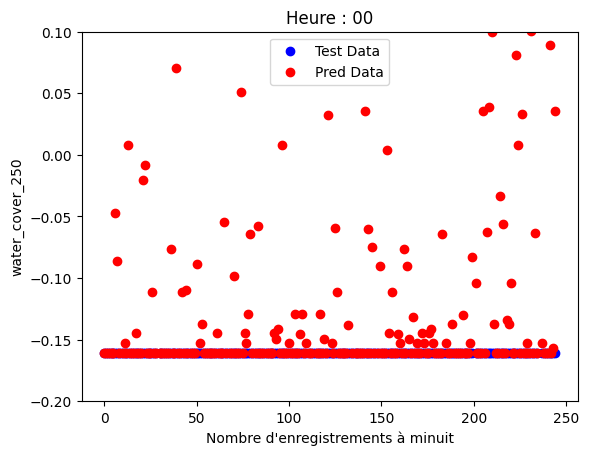

In [12]:
import matplotlib.pyplot as plt

# fig, axs = plt.subplots(2, 3, figsize=(8, 6))

# Plot data on the first subplot

plt.scatter(range(len(liste_tests['00'])), liste_tests['00'], label='Test Data', color='blue')
plt.scatter(range(len(liste_preds['00'])), liste_preds['00'], label='Pred Data', color='red')
plt.title('Heure : 00')

plt.ylim(-0.2,0.1)
plt.xlabel("Nombre d'enregistrements à minuit")
plt.ylabel("water_cover_250")

# # Plot data on the second subplot
# axs[1].plot(x, y2)
# axs[1].set_title('Subplot 2')

# # Adjust layout
# plt.tight_layout()

# Ajouter la légende
plt.legend()

# Show the plot
plt.show()


### Affichage

In [15]:
relative_MAE_aube = {}
for cible in df_cibles.columns:

  # Afficher pour chaque heure
  liste_preds = {'00' : [], '01' : [], '02' : [], '03' : [], '04' : [], '05' : []}
  liste_tests = {'00' : [], '01' : [], '02' : [], '03' : [], '04' : [], '05' : []}

  X_test = X_test_aube[cible]
  y_test = y_test_aube[cible]
  y_pred = predictions_aube[cible]

  # classer les prédictions et les valeurs de test dans les listes d'heures
  for i in range(len(X_test_heures)):
    file_name_parts = df_heures.iloc[i].split('_')
    horaire = file_name_parts[2]
    heure = horaire[:2]
    liste_preds[heure].append(y_pred[i])
    liste_tests[heure].append(y_test.iloc[i])

  # MAE relatif sur 00-02

  preds = np.array(liste_preds['00'] + liste_preds['01'] + liste_preds['02'])
  tests = np.array(liste_tests['00'] + liste_tests['01'] + liste_tests['02'])

  mae = np.abs(preds - tests)

  mae_relatif1 = np.mean(mae) / np.mean(tests)
  print('MAE relatif sur 00-02 sur', cible, ' : ', mae_relatif1)

  # MAE relatif sur 03-05

  preds = np.array(liste_preds['03'] + liste_preds['04'] + liste_preds['05'])
  tests = np.array(liste_tests['03'] + liste_tests['04'] + liste_tests['05'])

  mae = np.abs(preds - tests)

  mae_relatif2 = np.mean(mae) / np.mean(tests)
  print('MAE relatif sur 03-05 sur', cible, ' : ', mae_relatif2)
  print('-----------------------------------------------------------------------------------------------------')
  relative_MAE_aube[cible] = (mae_relatif1, mae_relatif2)



MAE relatif sur 00-02 sur SMMini  :  -6.203314915592594
MAE relatif sur 03-05 sur SMMini  :  19.84930665763793
-----------------------------------------------------------------------------------------------------
MAE relatif sur 00-02 sur LAT  :  11.421997688523856
MAE relatif sur 03-05 sur LAT  :  93.77365299075151
-----------------------------------------------------------------------------------------------------
MAE relatif sur 00-02 sur LON  :  -44.40683546531973
MAE relatif sur 03-05 sur LON  :  14.034594283425559
-----------------------------------------------------------------------------------------------------
MAE relatif sur 00-02 sur total_edge_length_100  :  14.101337815988183
MAE relatif sur 03-05 sur total_edge_length_100  :  -17.29703382419087
-----------------------------------------------------------------------------------------------------
MAE relatif sur 00-02 sur edge_density_100  :  14.357581631541132
MAE relatif sur 03-05 sur edge_density_100  :  -17.40600181512

# Matin

In [ ]:
# Séparer des prédicteurs et des cibles
df_predicteurs = df_matin[liste_predicteurs]
df_cibles = df_matin[liste_a_predire]

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

modeles_matin = {}
y_test_matin = {}
X_test_matin = {}

for cible in df_cibles.columns:
    model = RandomForestRegressor()
    # Ensembles de train et de test
    X_train, X_test, y_train, y_test = train_test_split(df_predicteurs, df_cibles[cible], test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    modeles_matin[cible] = model
    y_test_matin[cible] = y_test
    X_test_matin[cible] = X_test
    print('training terminé : ' + cible)

training terminé : SMMini
training terminé : LAT
training terminé : LON
training terminé : total_edge_length_100
training terminé : edge_density_100
training terminé : Shannon_landscape_diversity_100
training terminé : grass_and_shub_cover_100
training terminé : deciduous_forest_cover_100
training terminé : coniferous_forest_cover_100
training terminé : mineral_cover_100
training terminé : water_cover_100
training terminé : total_edge_length_250
training terminé : edge_density_250
training terminé : Shannon_landscape_diversity_250
training terminé : grass_and_shub_cover_250
training terminé : deciduous_forest_cover_250
training terminé : coniferous_forest_cover_250
training terminé : mineral_cover_250
training terminé : water_cover_250
training terminé : total_edge_length_500
training terminé : edge_density_500
training terminé : Shannon_landscape_diversity_500
training terminé : grass_and_shub_cover_500
training terminé : deciduous_forest_cover_500
training terminé : coniferous_forest

In [ ]:
import numpy as np

predictions_matin = {}
erreurs_relatives = {}
for cible in df_cibles.columns:
  modele = modeles_matin[cible]
  X_test = X_test_matin[cible]
  y_test = y_test_matin[cible]
  y_pred = modele.predict(X_test)
  predictions_matin[cible] = y_pred
  erreur_relative = np.abs((y_pred- y_test) / y_test) * 100
  moyenne_relative = np.mean(erreur_relative, axis= 0)
  erreurs_relatives[cible] = moyenne_relative

In [ ]:
# Obtenir les meilleurs prédictions
erreurs_relatives = dict(sorted(erreurs_relatives.items(), key=lambda item: item[1], reverse=False))

print(erreurs_relatives)

{'water_cover_250': 50.559531429090484, 'ice_and_snow_cover_500': 52.66246657930006, 'deciduous_forest_cover_100': 74.27514324340031, 'water_cover_100': 83.94382332649295, 'LON': 86.5947823179276, 'Shannon_landscape_diversity_250': 92.5129053892529, 'mineral_cover_250': 93.13946021627925, 'water_cover_500': 94.08492876078762, 'mineral_cover_500': 102.96860118883946, 'edge_density_500': 109.42559541414589, 'total_edge_length_500': 111.01948009747021, 'coniferous_forest_cover_500': 120.80404495050573, 'mineral_cover_100': 128.7689478680827, 'total_edge_length_100': 130.94533515982215, 'edge_density_100': 131.52445566231748, 'coniferous_forest_cover_100': 134.08683937143036, 'total_edge_length_250': 149.57454816148118, 'edge_density_250': 150.73199665976594, 'deciduous_forest_cover_250': 152.97621367111898, 'grass_and_shub_cover_100': 156.60315381804656, 'coniferous_forest_cover_250': 158.87376013190254, 'grass_and_shub_cover_250': 163.7462567322565, 'LAT': 170.8203961355, 'deciduous_fore

### Affichage

In [ ]:
# premier affichage pour water_cover_250
df_heures = df_original_matin['file_name']

X_train_heures, X_test_heures, y_train_heures, y_test_heures = train_test_split(df_heures, df_cibles['water_cover_250'], test_size=0.2, random_state=42)

# Afficher pour chaque heure
liste_preds = {'06' : [], '07' : [], '08' : [], '09' : [], '10' : [], '11' : []}
liste_tests = {'06' : [], '07' : [], '08' : [], '09' : [], '10' : [], '11' : []}

X_test = X_test_matin['water_cover_250']
y_test = y_test_matin['water_cover_250']
y_pred = predictions_matin['water_cover_250']

# classer les prédictions et les valeurs de test dans les listes d'heures
for i in range(len(X_test_heures)):
  file_name_parts = df_heures.iloc[i].split('_')
  horaire = file_name_parts[2]
  heure = horaire[:2]
  liste_preds[heure].append(y_pred[i])
  liste_tests[heure].append(y_test.iloc[i])


print(len(liste_preds['06']) + len(liste_preds['07']) + len(liste_preds['08']) + len(liste_preds['09']) + len(liste_preds['10'])+ len(liste_preds['11']) == len(y_test_heures))


True


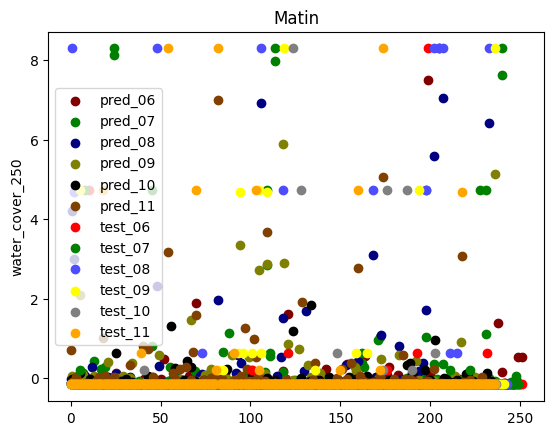

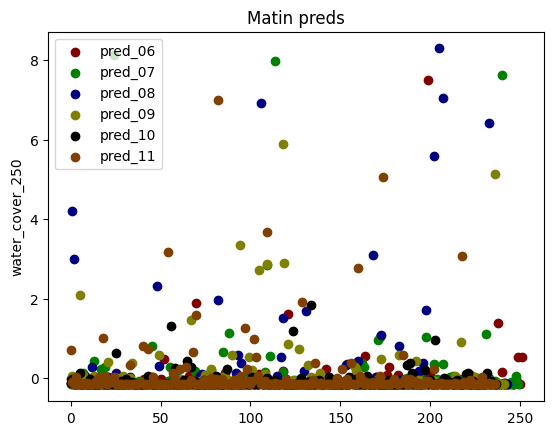

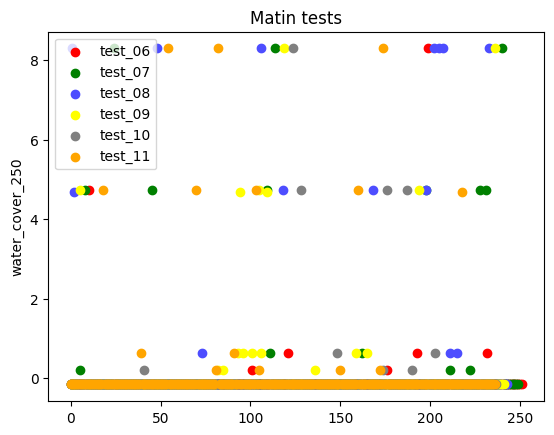

In [ ]:
import matplotlib.pyplot as plt

# fig, axs = plt.subplots(2, 3, figsize=(8, 6))

# Plot data on the first subplot

plt.scatter(range(len(liste_preds['06'])), liste_preds['06'], label='pred_06', color=(0.5, 0, 0))
plt.scatter(range(len(liste_preds['07'])), liste_preds['07'], label='pred_07', color=(0, 0.5, 0))
plt.scatter(range(len(liste_preds['08'])), liste_preds['08'], label='pred_08', color=(0, 0, 0.5))
plt.scatter(range(len(liste_preds['09'])), liste_preds['09'], label='pred_09', color=(0.5, 0.5, 0))
plt.scatter(range(len(liste_preds['10'])), liste_preds['10'], label='pred_10', color='black')
plt.scatter(range(len(liste_preds['11'])), liste_preds['11'], label='pred_11', color=(0.5, 0.25, 0))

plt.scatter(range(len(liste_tests['06'])), liste_tests['06'], label='test_06', color='red')
plt.scatter(range(len(liste_tests['07'])), liste_tests['07'], label='test_07', color='green')
plt.scatter(range(len(liste_tests['08'])), liste_tests['08'], label='test_08', color=(0.3, 0.3, 1))
plt.scatter(range(len(liste_tests['09'])), liste_tests['09'], label='test_09', color='yellow')
plt.scatter(range(len(liste_tests['10'])), liste_tests['10'], label='test_10', color='grey')
plt.scatter(range(len(liste_tests['11'])), liste_tests['11'], label='test_11', color='orange')
plt.ylabel('water_cover_250')
plt.title('Matin')



# # Plot data on the second subplot
# axs[1].plot(x, y2)
# axs[1].set_title('Subplot 2')

# # Adjust layout
# plt.tight_layout()

# Ajouter la légende
plt.legend()

# Show the plot
plt.show()

plt.scatter(range(len(liste_preds['06'])), liste_preds['06'], label='pred_06', color=(0.5, 0, 0))
plt.scatter(range(len(liste_preds['07'])), liste_preds['07'], label='pred_07', color=(0, 0.5, 0))
plt.scatter(range(len(liste_preds['08'])), liste_preds['08'], label='pred_08', color=(0, 0, 0.5))
plt.scatter(range(len(liste_preds['09'])), liste_preds['09'], label='pred_09', color=(0.5, 0.5, 0))
plt.scatter(range(len(liste_preds['10'])), liste_preds['10'], label='pred_10', color='black')
plt.scatter(range(len(liste_preds['11'])), liste_preds['11'], label='pred_11', color=(0.5, 0.25, 0))

plt.ylabel('water_cover_250')
plt.title('Matin preds')

# Ajouter la légende
plt.legend()

# Show the plot
plt.show()

plt.scatter(range(len(liste_tests['06'])), liste_tests['06'], label='test_06', color='red')
plt.scatter(range(len(liste_tests['07'])), liste_tests['07'], label='test_07', color='green')
plt.scatter(range(len(liste_tests['08'])), liste_tests['08'], label='test_08', color=(0.3, 0.3, 1))
plt.scatter(range(len(liste_tests['09'])), liste_tests['09'], label='test_09', color='yellow')
plt.scatter(range(len(liste_tests['10'])), liste_tests['10'], label='test_10', color='grey')
plt.scatter(range(len(liste_tests['11'])), liste_tests['11'], label='test_11', color='orange')
plt.ylabel('water_cover_250')
plt.title('Matin')

plt.ylabel('water_cover_250')
plt.title('Matin tests')

# Ajouter la légende
plt.legend()

# Show the plot
plt.show()

# Aprem

In [ ]:
# Séparer des prédicteurs et des cibles
df_predicteurs = df_aprem[liste_predicteurs]
df_cibles = df_aprem[liste_a_predire]

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

modeles_aprem = {}
y_test_aprem = {}
X_test_aprem = {}

for cible in df_cibles.columns:
    model = RandomForestRegressor()
    # Ensembles de train et de test
    X_train, X_test, y_train, y_test = train_test_split(df_predicteurs, df_cibles[cible], test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    modeles_aprem[cible] = model
    y_test_aprem[cible] = y_test
    X_test_aprem[cible] = X_test
    print('training terminé : ' + cible)

training terminé : SMMini
training terminé : LAT
training terminé : LON
training terminé : total_edge_length_100
training terminé : edge_density_100
training terminé : Shannon_landscape_diversity_100
training terminé : grass_and_shub_cover_100
training terminé : deciduous_forest_cover_100
training terminé : coniferous_forest_cover_100
training terminé : mineral_cover_100
training terminé : water_cover_100
training terminé : total_edge_length_250
training terminé : edge_density_250
training terminé : Shannon_landscape_diversity_250
training terminé : grass_and_shub_cover_250
training terminé : deciduous_forest_cover_250
training terminé : coniferous_forest_cover_250
training terminé : mineral_cover_250
training terminé : water_cover_250
training terminé : total_edge_length_500
training terminé : edge_density_500
training terminé : Shannon_landscape_diversity_500
training terminé : grass_and_shub_cover_500
training terminé : deciduous_forest_cover_500
training terminé : coniferous_forest

In [ ]:
import numpy as np

predictions_aprem = {}
erreurs_relatives = {}
for cible in df_cibles.columns:
  modele = modeles_aprem[cible]
  X_test = X_test_aprem[cible]
  y_test = y_test_aprem[cible]
  y_pred = modele.predict(X_test)
  predictions_aprem[cible] = y_pred
  erreur_relative = np.abs((y_pred- y_test) / y_test) * 100
  moyenne_relative = np.mean(erreur_relative, axis= 0)
  erreurs_relatives[cible] = moyenne_relative

In [ ]:
# Obtenir les meilleurs prédictions
erreurs_relatives = dict(sorted(erreurs_relatives.items(), key=lambda item: item[1], reverse=False))

print(erreurs_relatives)

{'water_cover_250': 53.14567323066048, 'ice_and_snow_cover_500': 78.89442434461361, 'deciduous_forest_cover_100': 79.0292344984138, 'water_cover_100': 89.30659713533598, 'mineral_cover_500': 91.73837723755639, 'mineral_cover_250': 93.96264107161703, 'Shannon_landscape_diversity_250': 94.27335287436361, 'LON': 94.83795683665674, 'mineral_cover_100': 96.59011711647223, 'edge_density_500': 106.34849917384845, 'total_edge_length_500': 108.33832784083214, 'coniferous_forest_cover_100': 111.94761374983963, 'edge_density_100': 123.98125600093431, 'total_edge_length_100': 124.52721030226346, 'edge_density_250': 148.32282448759028, 'total_edge_length_250': 150.80619681761289, 'grass_and_shub_cover_100': 151.26251277862642, 'coniferous_forest_cover_250': 167.07306055375972, 'water_cover_500': 167.18813276817784, 'deciduous_forest_cover_500': 169.8481808043885, 'grass_and_shub_cover_500': 171.82013772852363, 'grass_and_shub_cover_250': 173.11363679635855, 'Shannon_landscape_diversity_500': 202.90

# Soir

In [ ]:
# Séparer des prédicteurs et des cibles
df_predicteurs = df_soir[liste_predicteurs]
df_cibles = df_soir[liste_a_predire]

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

modeles_soir = {}
y_test_soir = {}
X_test_soir = {}

for cible in df_cibles.columns:
    model = RandomForestRegressor()
    # Ensembles de train et de test
    X_train, X_test, y_train, y_test = train_test_split(df_predicteurs, df_cibles[cible], test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    modeles_soir[cible] = model
    y_test_soir[cible] = y_test
    X_test_soir[cible] = X_test
    print('training terminé : ' + cible)

training terminé : SMMini
training terminé : LAT
training terminé : LON
training terminé : total_edge_length_100
training terminé : edge_density_100
training terminé : Shannon_landscape_diversity_100
training terminé : grass_and_shub_cover_100
training terminé : deciduous_forest_cover_100
training terminé : coniferous_forest_cover_100
training terminé : mineral_cover_100
training terminé : water_cover_100
training terminé : total_edge_length_250
training terminé : edge_density_250
training terminé : Shannon_landscape_diversity_250
training terminé : grass_and_shub_cover_250
training terminé : deciduous_forest_cover_250
training terminé : coniferous_forest_cover_250
training terminé : mineral_cover_250
training terminé : water_cover_250
training terminé : total_edge_length_500
training terminé : edge_density_500
training terminé : Shannon_landscape_diversity_500
training terminé : grass_and_shub_cover_500
training terminé : deciduous_forest_cover_500
training terminé : coniferous_forest

In [ ]:
import numpy as np

predictions_soir = {}
erreurs_relatives = {}
for cible in df_cibles.columns:
  modele = modeles_soir[cible]
  X_test = X_test_soir[cible]
  y_test = y_test_soir[cible]
  y_pred = modele.predict(X_test)
  predictions_soir[cible] = y_pred
  erreur_relative = np.abs((y_pred- y_test) / y_test) * 100
  moyenne_relative = np.mean(erreur_relative, axis= 0)
  erreurs_relatives[cible] = moyenne_relative

In [ ]:
# Obtenir les meilleurs prédictions
erreurs_relatives = dict(sorted(erreurs_relatives.items(), key=lambda item: item[1], reverse=False))

print(erreurs_relatives)

{'water_cover_250': 45.24568134224388, 'water_cover_500': 65.16564612159023, 'deciduous_forest_cover_100': 77.4402010590907, 'Shannon_landscape_diversity_250': 87.74203083699764, 'mineral_cover_250': 93.36667124866273, 'water_cover_100': 96.28995154149466, 'ice_and_snow_cover_500': 96.81860178003046, 'Shannon_landscape_diversity_100': 97.00664918631013, 'mineral_cover_100': 97.10354582268211, 'LON': 98.45132895568626, 'mineral_cover_500': 109.25750274588079, 'coniferous_forest_cover_500': 113.83250471711534, 'coniferous_forest_cover_100': 116.65099798465246, 'total_edge_length_100': 120.55221915845748, 'edge_density_100': 124.38320975760733, 'total_edge_length_250': 125.94076986597285, 'edge_density_250': 126.98146965409202, 'deciduous_forest_cover_500': 137.05065926725692, 'grass_and_shub_cover_100': 144.0474788929975, 'deciduous_forest_cover_250': 144.77408637124273, 'grass_and_shub_cover_250': 149.85564362868004, 'coniferous_forest_cover_250': 164.9216568271888, 'grass_and_shub_cove